# Instrumental Variables

*How to estimate causal effects when you cannot randomize treatment.*

A/B tests are the golden standard of causal inference because they allow us to make valid causal statements under minimal assumptions, thanks to **randomization**. In fact, by randomly assigning a **treatment** (a drug, ad, product, ...), we are able to compare the **outcome** of interest (a disease, firm revenue, customer satisfaction, ...) across **subjects** (patients, users, customers, ...) and attribute the average difference in outcomes to the causal effect of the treatment.

However, in many settings, it is **not possible to randomize** the treatment, for either ethical, legal, or practical reasons. One common online setting is on-demand features, such as subscriptions or premium memberships. Other settings include features for which we cannot discriminate customers, like insurance contracts, or features that are so deeply hard-coded that an experiment might not be worth the effort. Can we still do valid causal inference in those settings?

The answer is yes, thanks to **instrumental variables** and the corresponding experimental design called **encouragement design**. In many of the settings mentioned above, we cannot randomly *assign* treatment, but we can *encourage* customers to take it. For example, we can offer a subscription discount or we can change the order in which options are presented. While customers retain the ultimate word on taking the treatment, we are still able to estimate a causal treatment effect. Let's see how.

## Evaluating Subscription Programs

In the rest of the article, we are going to use a toy example. Suppose we were a product company starting a weekly **newsletter** to promote product and feature updates. We would like to understand whether the newsletter is worth the effort and whether it is ultimately successful in increasing **sales**. Unfortunately, we cannot run a standard A/B test since we cannot force customers to **subscribe** to the newsletter. Does it mean we cannot evaluate the newsletter? Not exactly. 

Let's assume we have also run an A/B test on a new **notification** on our mobile app that promotes the newsletter. A random sample of our customers has received the notification, while a random sample has not. Perhaps this A/B test was not related to the evaluation of the causal effect of the **newsletter** at all, as it sometimes happens in large companies. However, this is a great opportunity for a data scientist interested in understanding the impact of the newsletter on **sales**.

Let's first have a look at the data. I import the data-generating process from [src.dgp](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/dgp.py) and some plotting utilities from [src.utils](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/utils.py).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *
from src.dgp import dgp_notification_newsletter

In [3]:
dgp = dgp_notification_newsletter(n=10_000)
df = dgp.generate_data()
df.head()

,spend_old,notification,subscription,spend
0,9.47,0,0,10.04
1,11.18,1,1,16.49
2,11.52,0,0,9.50
3,9.03,1,0,10.12
4,7.02,0,0,7.18


We have information on *10,000* customers, for whom we observe whether or not they received the `notification`, whether they `subscribed` to the newsletter, and how much they `spent`. Moreover, we also observe how much they spent before the introduction of the subscription program (`spent_old`). For the rest of the article, we will label these variables as follows:

- `notification`, the **treatment assignment**, *Z*
- `subscription`, the **treatment status**, *W*
- `spend_old`, a **feature** or control variable, *X*
- `spend`, the **outcome**, *Y*

A **naive approach** would be to compare the difference in `spend` between customers that `subscribed` and those who didn't. The corresponding causal object or *estimand* is 
 
$$
\tau_{W \to Y} = \mathbb{E} \Big[ \text{spend} \ \Big| \ \text{subscription} = 1 \Big] - \mathbb{E} \Big[ \text{spend} \ \Big| \ \text{subscription} = 0 \Big]
$$

Let's visualize the average `spend` for the two groups.

In [4]:
def plot_group_comparison(df, x, y, title, xticks):
    fig, ax = plt.subplots()
    g = sns.barplot(data=df.sort_values([y, x]), x=x, y=y, ci=None, ax=ax)
    g.set(ylabel="", xlabel="")
    ax.tick_params(axis='x', which='major', labelsize=16)
    ax.set_xticklabels(xticks)
    diff = df.loc[df[x]==1, y].mean() - df.loc[df[x]==0, y].mean()
    plt.suptitle(title)
    plt.title(f"Difference: {diff:.2f}", fontsize=16, fontweight=None, y=0.95)

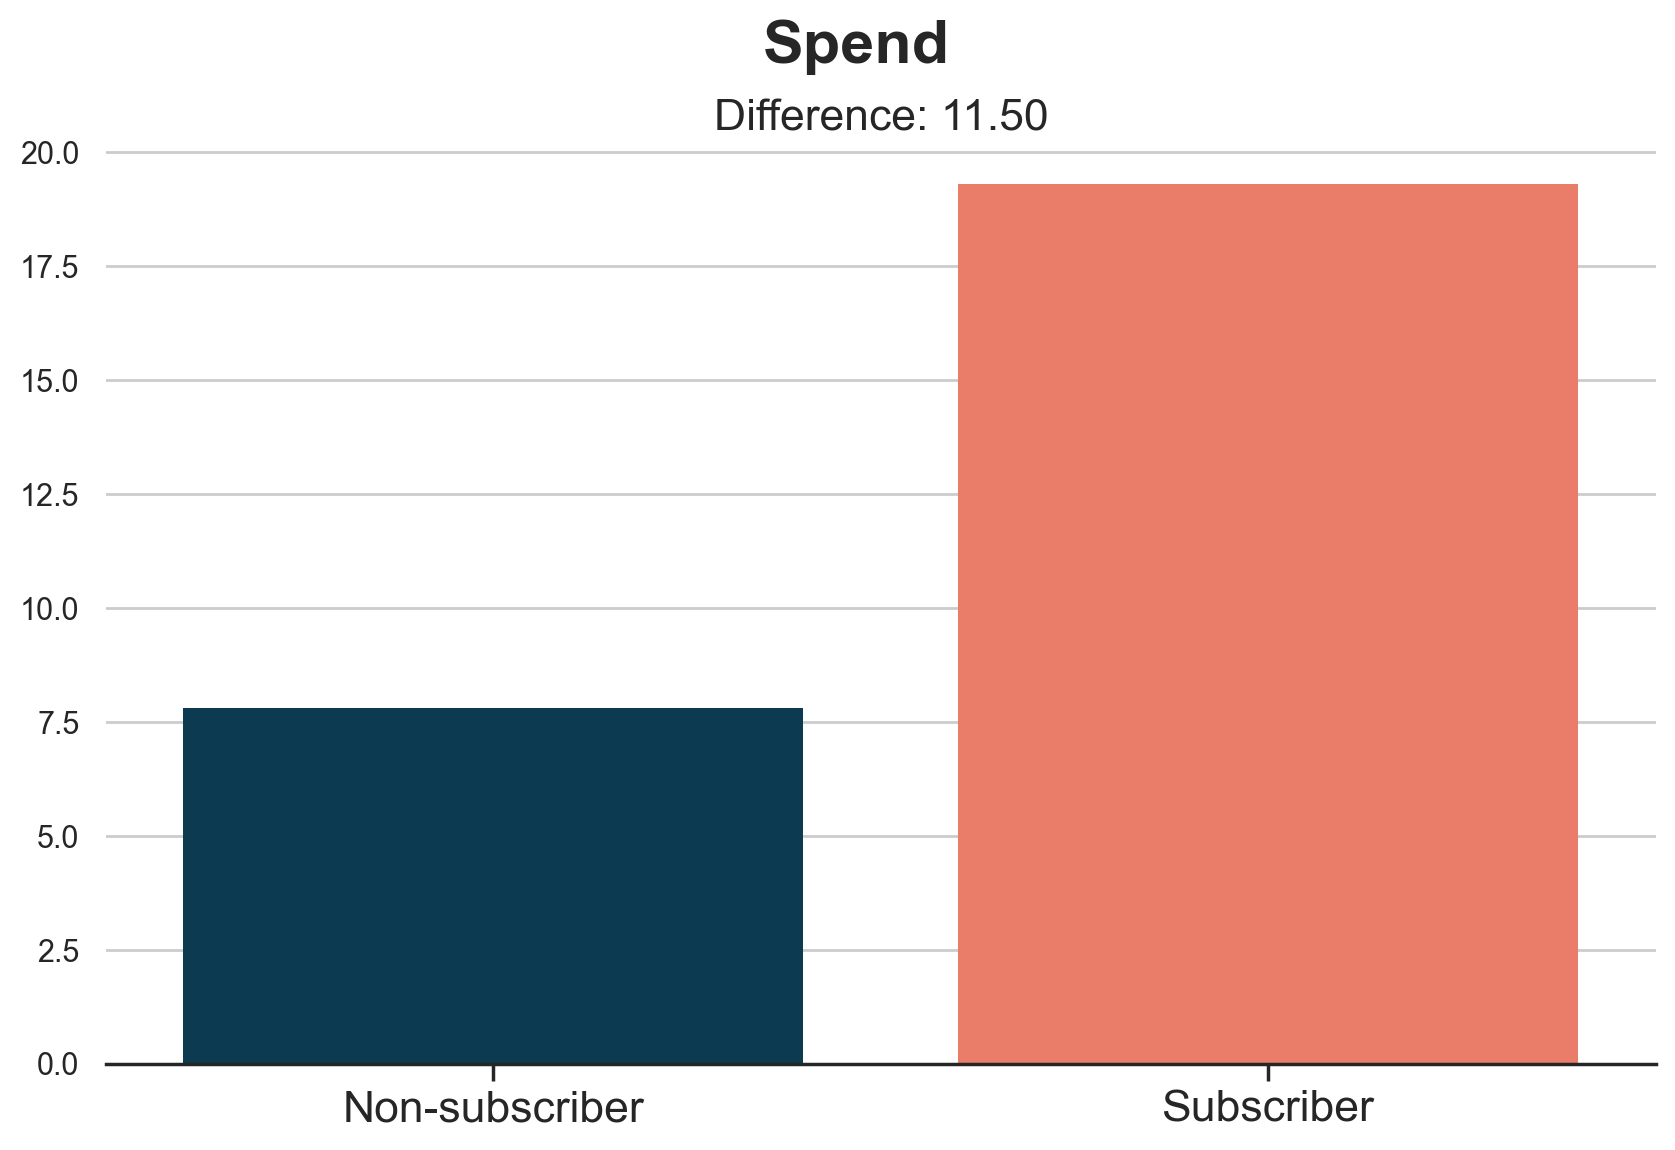

In [5]:
plot_group_comparison(df, x="subscription", y="spend", title="Spend", xticks=["Non-subscriber", "Subscriber"])

Subscribers spend on average *11.5$* more than non-subscribers. But is it a **causal** effect?

We can imagine that customers who are more active and more interested in our product will also be more interested in hearing news about it. For example, we can imagine that customers who have more **budget** to spend will also want to spend it better and subscribe to the newsletter. 

We can represent the relationship between the variables in the following Directed Acyclic Graph (DAG). If you never heard of DAGs, I recommend reading my [introductory article](https://towardsdatascience.com/b63dc69e3d8c) first.

https://towardsdatascience.com/b63dc69e3d8c

In the plot, we represent variables with circles and causal relationships with arrows.

```mermaid
flowchart LRclassDef included fill:#DCDCDC,stroke:#000000,stroke-width:2px;classDef excluded fill:#ffffff,stroke:#000000,stroke-width:2px;classDef unobserved fill:#ffffff,stroke:#000000,stroke-width:2px,stroke-dasharray: 5 5;U((U: budget))W((W: subscription))Y((Y: spend))U --> WU --> YW --> Yclass W,Y included;class U unobserved;linkStyle 0,1 stroke:#ff6e54,stroke-width:4px;linkStyle 2 stroke:#003f5c,stroke-width:4px;
```

Technically speaking, customer's **budget** is an unobservable confounder that opens a spurious path between our treatment, the `subscription`, and the outcome, customers' `spend`. Because of this, we cannot interpret the difference-in-means estimate of *11.5\$* as causal.

What can we do?

## Encouragement Design

Unfortunately, we cannot run an A/B test because we cannot force people to subscribe to the newsletter. However, we can *encourage* people to subscribe. For example, we can send them a mobile **notification** to advertise the newsletter. This setting is called an **encouragement design** since we do not randomize the treatment, but the encouragement. The encouragement, the `notification` in our setting, is also called **instrumental variable**.

It's important to stress that, while being randomly assigned, the encouragement does *not* correspond with the treatment of interest. In fact, some people will *not* subscribe despite receiving the notification, and some people will subscribe despite  *not* receiving the notification.

![img](fig/instrumental_variables1.png)

After adding the encouragement, the `notification`, the data-generating process can be represented with the following DAG.

```mermaid
flowchart LRclassDef included fill:#DCDCDC,stroke:#000000,stroke-width:2px;classDef excluded fill:#ffffff,stroke:#000000,stroke-width:2px;classDef unobserved fill:#ffffff,stroke:#000000,stroke-width:2px,stroke-dasharray: 5 5;U((U: budget))Z((Z: notification))W((W: subscription))Y((Y: spend))U -.-> WU -.-> YZ --> WW --> Yclass Z,W,Y included;class U unobserved;linkStyle 0,1 stroke-width:4px;linkStyle 2 stroke:#003f5c,stroke-width:4px;linkStyle 3 stroke:#2db88b,stroke-width:4px;
```

Note that now we have closed the open path between `subscription` and `spend`. Therefore, we can estimate the causal effect of the subscription on the probability of making a sale. Let's see how.

First, we would like to understand whether the `notification` is effective or not. This is often referred to as **strength** of the instrument. Thanks to randomization, we can attribute the average difference in `spend` between people who received the `notification` and people who did not, to the treatment itself.

$$
\tau_{Z \to Y} = \mathbb{E} \Big[ \text{spend} \ | \ \text{notification} = 1 \Big] - \mathbb{E} \Big[ \text{spend} \ | \ \text{notification} = 0 \Big]
$$

Let's visualize the corresponding difference-in-means estimate.

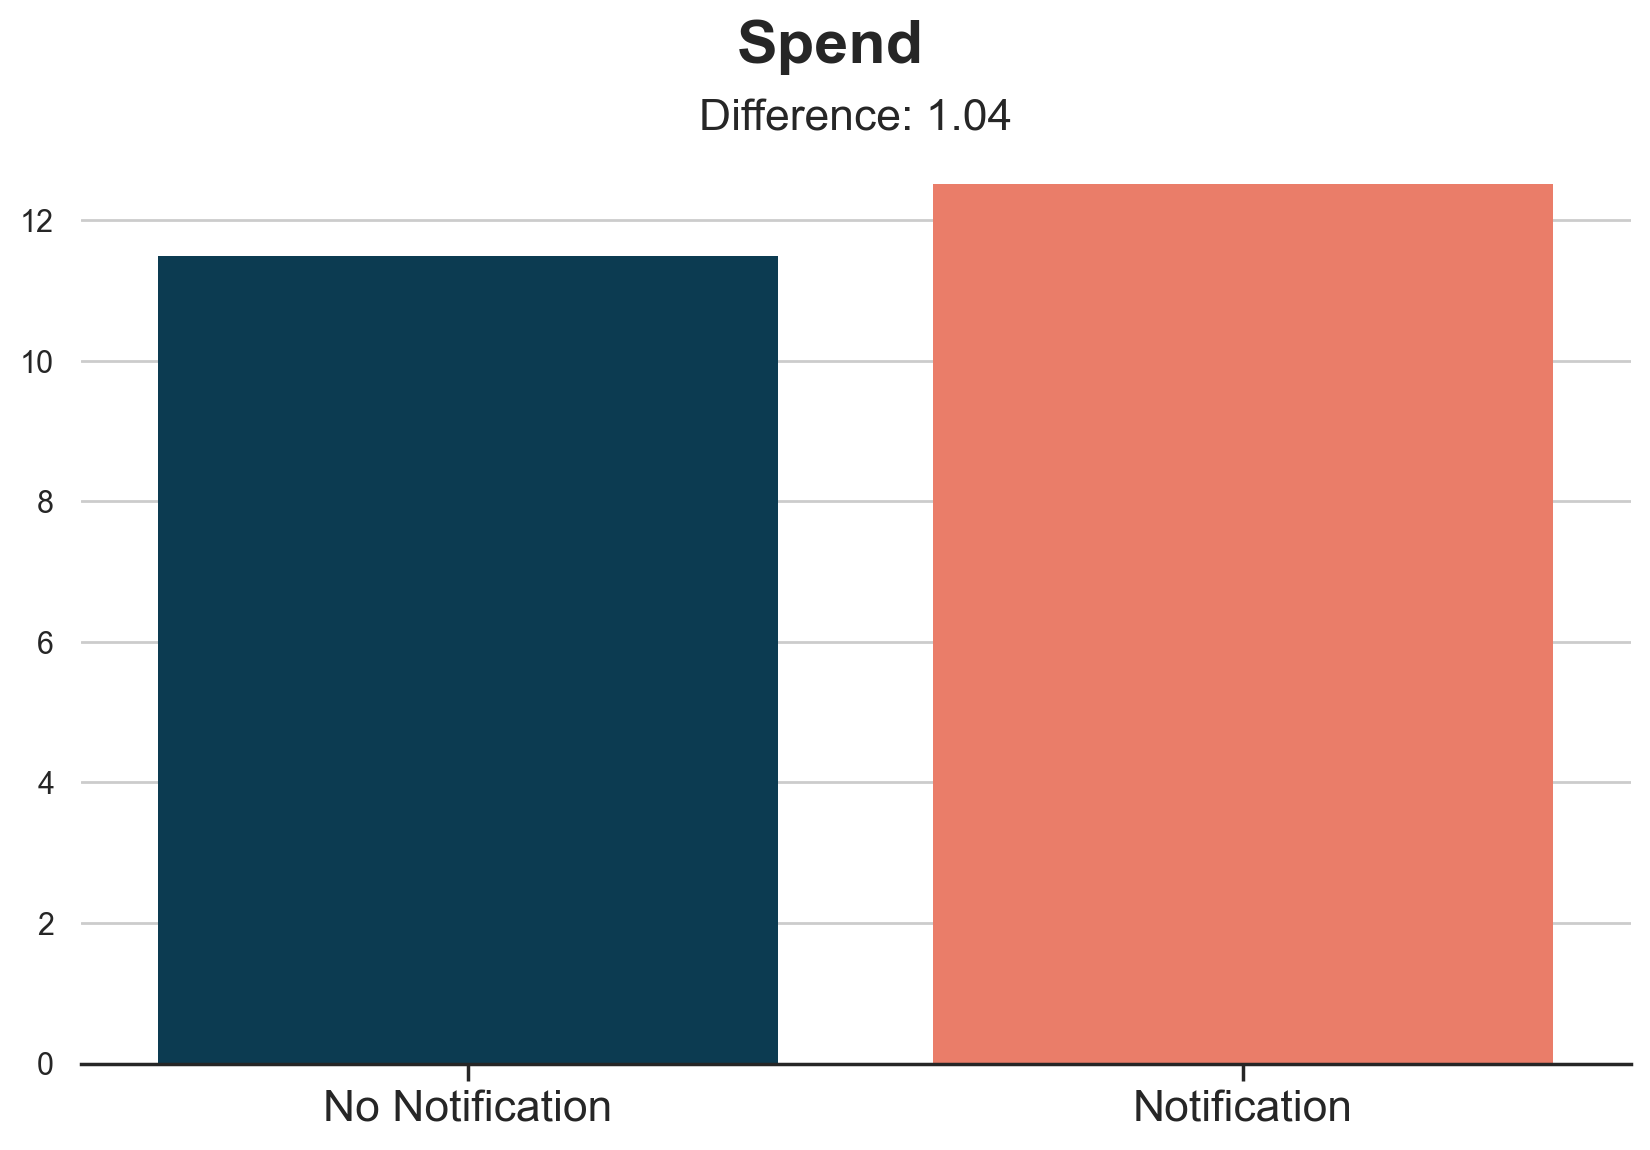

In [6]:
plot_group_comparison(df, x="notification", y="spend", title="Spend", xticks=["No Notification", "Notification"])

It seems that customers who received the `notification` spend on average *1\$* more than customers who didn't receive it. This is a sensibly lower number than the *11.5\$* we estimated before.

However, the effect of the `notification` on `spend` is not what we are interested in. We would rather know the effect of the `subscription` on `spend`. In fact, not all customers who receive the email subscribe to the newsletter. And vice-versa, some people subscribe to the newsletter even without the notification. 

This means that the effect that we have just computed is **diluted** by the fact that some people do not comply with our incentive, the `notification`. We have to attribute it *only* to the customers who changed their minds because of the newsletter. How many are these customers?

Let's compute the probability of `subscription`, by treatment group. 

$$
\tau_{Z \to W} = \mathbb{E} \Big[ \text{subscription} \ | \ \text{notification} = 1 \Big] - \mathbb{E} \Big[ \text{subscription} \ | \ \text{notification} = 0 \Big]
$$

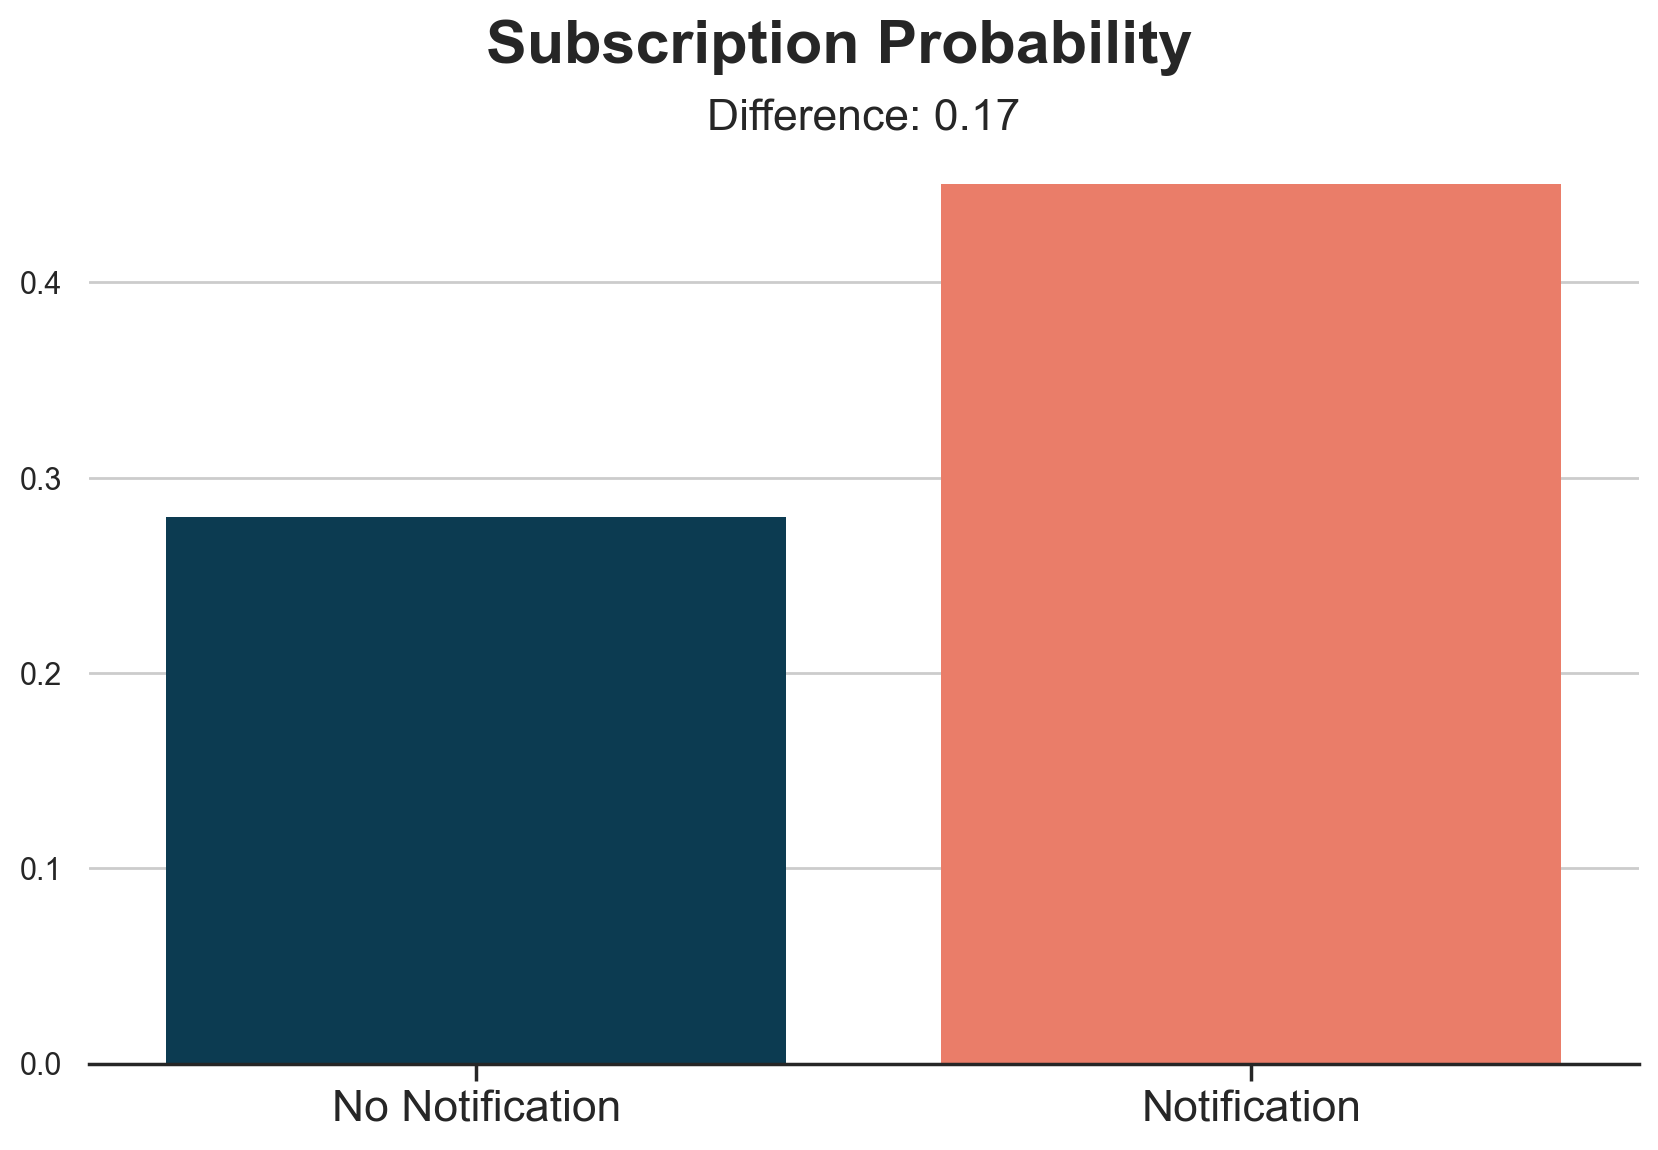

In [7]:
plot_group_comparison(df, x="notification", y="subscription", title="Subscription Probability", xticks=["No Notification", "Notification"])

Customers that received the `notification` have a *17%* higher `subscription` probability. In other words, it seems that the `notification` is able to make *17%* of our customers change their minds. From the control group, we learned that *28%* of them would have subscribed anyway, while we were unable to convince the remaining *55%*. 

We now have all the ingredients we need for our main analysis

## Instrumental Variables (IV)

In this case, with a binary instrument, the `notification`, a binary treatment, the `subscription` decision, and a 50-50 treatment assignment probability, we can get a very simple **intuition** of how instrumental variables work.

We have four groups of customers, depending on whether they received the notification or not, and wether they subscribed or not.

In [8]:
df.groupby(["notification", "subscription"]).agg(spend=("spend", "sum"), customers=("spend", "count")).iloc[::-1].T.round(0)

notification        1                 0         
subscription        1        0        1        0
spend         42643.0  19958.0  27857.0  29566.0
customers      2253.0   2747.0   1400.0   3600.0

Let's visualize the total spend and the total number of customers within each bucket.

![img](fig/instrumental_variables2.png)

Comparing treatment (`notification`) and control group, we see that the notification has generated an increase in `spend` of *5k€* (*43 + 20 - 28 - 30*). In order to recover the causal effect of interest, we just need to attribute the *5k€* incremental `spend` to the *800* (*2200 - 1400*) customers that decided to `subscribe` because of the `notification`. The result is exactly *5k€ / 800 = 6€* per customer!

![img](fig/instrumental_variables3.png)

More generally, the IV estimand is given by the **ratio of two causal effects**: the effect of the instrument (or encouragement, or assignment) *Z*, on the outcome *Y*, over the effect of the instrument *Z* on the treatment (or endogenous variable) *W*.

$$
\tau_{IV} = \frac{\tau_{Z \to Y}}{\tau_{Z \to W}} = \frac{\mathbb{E} \Big[ \text{spend} \ | \ \text{notification} = 1 \Big] - \mathbb{E} \Big[ \text{spend} \ | \ \text{notification} = 0 \Big]}{\mathbb{E} \Big[ \text{subscription} \ | \ \text{notification} = 1 \Big] - \mathbb{E} \Big[ \text{subscription} \ | \ \text{notification} = 0 \Big]}
$$

To compute the IV estimate we replace the expected values with the empirical averages. In practice, in our case, we just divide the two difference-in-means estimates we computed in the plots in the previous section.

In [12]:
tau_ZY = df.loc[df.notification == 1, "spend"].mean() - df.loc[df.notification == 0, "spend"].mean()
tau_ZW = df.loc[df.notification == 1, "subscription"].mean() - df.loc[df.notification == 0, "subscription"].mean()
tau_ZY / tau_ZW

6.070222743259094

Our instrumental variable estimate of the effect of the `subscription` program on `spend` is *6$*, as anticipated in the illustrations above! Note that the math in the illustration works *only* in the special case of an exact 50-50 assignment.

More generally, it can be shown that the formula of the IV estimator is given by a ratio of covariances,

$$
\tau_{IV} = \frac{\text{Cov} (Z, Y)}{\text{Cov} (Z, W)}
$$

or, in matrix notation,

$$
\tau_{IV} = \mathbb{E} \big[ ZW \big]^{-1} \mathbb{E} \big[ ZY \big]
$$

## IV Extensions

What would happen if we had more instruments or other control variables? For example, we could have run other experiments to encourage customers to `subscribe`. Or, as in our case, we could have other variables that we can add to the model in order to increase prediction accuracy, such as previous spend levels, `spend_old`. How do we include them in the model?

The long-story-short is that when we have multiple instruments, the instrumental variable formula can be rewritten as 

$$
\tau_{2SLS} = \mathbb{E} \big[ \hat{W} \hat{W} \big]^{-1} \mathbb{E} \big[ \hat{W} Y \big]
$$

where $\hat{W}$ is the projection of *W* onto *Z*, i.e. in practice the predicted treatment status, given the treatment assignment. This prediction step is called the **first stage**. This formula should remind you of the OLS estimator formula. Indeed, this is equivalent to a linear regression of our outcome *Y* on the predicted treatment *W*, given the assignment *Z*. This step is called the **second stage**. Overall, since the estimation procedure can be split into two separate stages, this is referred to as the **Two-Stage Least Squares (2SLS) Estimator**.

The two-stage formulation particularly evident in the implementation of most IV packages, where we express the treatment as the result of a regression on the instrument. In the [`IV2SLS`](https://bashtage.github.io/linearmodels/iv/iv/linearmodels.iv.model.IV2SLS.html) package this is done by using square brackets. 

In [10]:
from linearmodels.iv.model import IV2SLS as iv
model_iv = iv.from_formula("spend ~ 1 + [subscription ~ notification]", data=df).fit()
model_iv.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,9.7849,0.2083,46.973,0.0000,9.3766,10.193
subscription,6.0702,0.5548,10.942,0.0000,4.9829,7.1575


We can verify that this is algebraically equivalent to first regressing `subscription` on `notification` and then regressing `spend` on the predicted `subscription` probability. Below we run the two regressions and report the estimates from the second stage.

In [27]:
model_1st_stage = smf.ols("subscription ~ 1 + notification", data=df).fit()
df["subscription_hat"] = model_1st_stage.predict(df)
model_2nd_stage = smf.ols("spend ~ 1 + subscription_hat", data=df).fit()
model_2nd_stage.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9.7849,0.298,32.823,0.000,9.201,10.369
subscription_hat,6.0702,0.795,7.639,0.000,4.512,7.628


The coefficients are indeed identical!

Lastly, the two-stage formulation above should also make the inclusion of additional **covariates** quite intuitive. We just add the covariates to both stages. 

In [32]:
model_1st_stage = smf.ols("subscription ~ 1 + spend_old + notification", data=df).fit()
df["subscription_hat"] = model_1st_stage.predict(df)
model_2nd_stage_x = smf.ols("spend ~ 1 + spend_old + subscription_hat", data=df).fit()
model_2nd_stage_x.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3876,0.081,4.811,0.000,0.230,0.546
spend_old,0.9619,0.018,53.210,0.000,0.926,0.997
subscription_hat,5.9972,0.317,18.946,0.000,5.377,6.618


We can again verify that the estimated coefficients are identical.

In [29]:
model_iv = iv.from_formula("spend ~ 1 + spend_old + [subscription ~ notification]", data=df).fit()
model_iv.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,0.3876,0.0294,13.177,0.0000,0.3299,0.4452
spend_old,0.9619,0.0066,145.03,0.0000,0.9489,0.9749
subscription,5.9972,0.1161,51.652,0.0000,5.7696,6.2248


Including previous spend levels in the regression has indeed decreased the standard errors from *0.5* to *0.1*.

## The Limits of IV

The main limit of instrumental variables in an experimental setting, as analyzed in this article, is that they estimate a very "special" causal effect. As we have seen in the previous section, we have to re-scale the total effect by the number of customers who decided to `subscribe` *because of* the `newsletter`. This means that we can estimate the effect only for those customers who *complied* with our intervention. This set of customers is usually called **compliers** and the corresponding causal effect is called the **Local Average Treatment Effect (LATE)** or **Compliers Average Causal Effect (CACE)**.

We are unfortunately unable to say anything about customers who subscribed to the `newsletter` even without the `notification`, called the **always-takers**, and those that we couldn't convince with the `notification`, the **never-takers**.

Another limit of IV concerns its **assumptions**. In the last paragraph, we talked about three groups of customers, the compliers (our favorite one), always-takers, and never-takers. You might have noticed that this characterization implies the existence of a fourth group: the **defiers**. Those are the customers that would have `subscribed` to the newsletter if we had not received the `notification`. However, because of the notification, they changed their mind, *defying* the intent of the instrument.

![img](fig/instrumental_variables4.png)

In order to be able to draw causal conclusions, we have to assume that there are **no defiers** in the experiment, otherwise our re-scaling would be wrong and our estimates biased.

Another crucial assumption lurking in the background is what is usually called the **exclusion restriction**. In words, this assumption states that the instrument, the `notification`, only affects the outcome, `spend`, through the treatment, the `subscription`. A potential violation in our setting could be if the notification was *waking up* sleeping users. Imagine a customer who wanted to make a sale and already added items to the basket, but forgot to checkout. The subscription notification might remind the users to checkout and therefore directly impact `spend`. As you can imagine, the IV estimate would be biased because we are wrongly attributing some sales to the `subscription`, while they were a *direct* effect of the `notification` itself.

## Conclusion

In this article, we have introduced **instrumental variables** in an experimental setting. When we cannot randomize the treatment because of ethical, legal or technical constraints, we might still consider randomizing an **incentive** to take up the treatment. This allows us to make causal statements, but only for a subset of the overall population, the **compliers**, i.e. the customers that comply with our incentive and take up the treatment *because of* the incentive.

It's important to note that instrumental variables can be also used in **observational settings**. However, in that case, the **exclusion restriction** assumption that we mentioned in the previous section becomes harder to justify. In fact, we need a setting in which our instrument does not affect the outcome through *any other* channel besides the treatment. Technically, the exclusion restriction assumption is

$$
Y_i(W_i = w, Z_i = 1) = Y_i(W_i = w, Z_i = 0) \qquad \forall w, i
$$

This assumption is harder to justify when we do not control the design of the encouragement assignment. However, if satisfied, it opens the door to causal inference in completely new settings.

### References

- Spotify (2023), [Encouragement Designs and Instrumental Variables for A/B Testing](https://engineering.atspotify.com/2023/08/encouragement-designs-and-instrumental-variables-for-a-b-testing/)

- Goldsmith-Pinkham (2021), [Instrumental Variables](https://www.youtube.com/watch?v=LEAx0He_KBI) video lecture

- Ding (2023), [A First Course in Causal Inference](https://arxiv.org/abs/2305.18793) notes

### Related Articles

- [DAGs and Control Variables](https://towardsdatascience.com/b63dc69e3d8c)

- [Understanding Omitted Variable Bias](https://towardsdatascience.com/344ac1477699)

- [Understanding The Frisch-Waugh-Lovell Theorem](https://towardsdatascience.com/59f801eb3299)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/instrumental_variables.ipynb